In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from enum import Enum
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, \
                            f1_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/IA/IA2A2/DESAFIO2

/content/drive/MyDrive/IA/IA2A2/DESAFIO2


In [5]:
df = pd.read_csv('sensor.csv')

# Análise dos dados gerados pelos sensores de uma bomba

- [Dataset](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

- Vamos remover a coluna unnamed
- Existe campo data e machine_status que são strings, então farei a conversão da data e o machine status será convertido em numérico para facilitar as análises e calculos

In [7]:
df['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [8]:
class MachineStatus(Enum):
    NORMAL = 1
    BROKEN = 2
    RECOVERING = 3

df.head(5)

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [9]:
df.drop(df.columns[:1], axis=1, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d %H:%M:%S')
df['machine_status'] = df['machine_status'].apply(lambda x: MachineStatus[x].value)

df.head(5)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,1
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,1
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       220320 non-null  datetime64[ns]
 1   sensor_00       210112 non-null  float64       
 2   sensor_01       219951 non-null  float64       
 3   sensor_02       220301 non-null  float64       
 4   sensor_03       220301 non-null  float64       
 5   sensor_04       220301 non-null  float64       
 6   sensor_05       220301 non-null  float64       
 7   sensor_06       215522 non-null  float64       
 8   sensor_07       214869 non-null  float64       
 9   sensor_08       215213 non-null  float64       
 10  sensor_09       215725 non-null  float64       
 11  sensor_10       220301 non-null  float64       
 12  sensor_11       220301 non-null  float64       
 13  sensor_12       220301 non-null  float64       
 14  sensor_13       220301 non-null  flo

In [11]:
df.shape

(220320, 54)

- Como sensor_15 não possui nenhum dado, ele será removido
- O sensor_50 possui 35% dos registros ausentes, logo será removido 

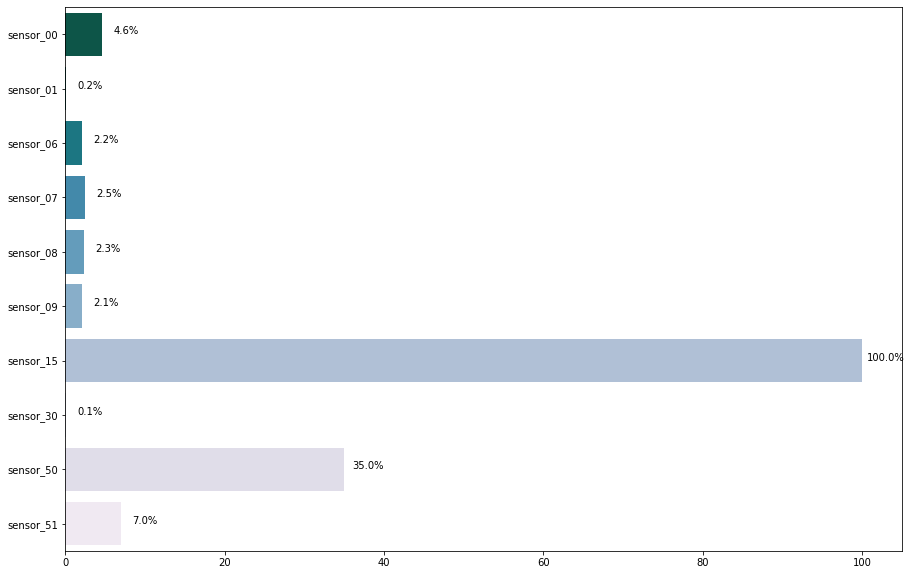

In [12]:
total_rows, _ = df.shape
labels = []
pct_missing_values = []

for column in df.columns[1:-1]:
  missing = df[column].isnull().sum() / total_rows * 100
  if missing < 0.1:
    continue

  labels.append(column)
  pct_missing_values.append(missing)

ax = sns.barplot(x=pct_missing_values, y=labels, palette='PuBuGn_r')
ax.figure.set_size_inches(15,10)
patches = ax.patches
for i, p in enumerate(patches):
   x = p.get_x() + p.get_width() + 3
   y = p.get_y() + p.get_height()/2
   ax.annotate('{:.1f}%'.format(pct_missing_values[i]), (x, y), ha='center')

In [13]:
df.drop('sensor_15', axis=1, inplace=True)
df.drop('sensor_50', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       220320 non-null  datetime64[ns]
 1   sensor_00       210112 non-null  float64       
 2   sensor_01       219951 non-null  float64       
 3   sensor_02       220301 non-null  float64       
 4   sensor_03       220301 non-null  float64       
 5   sensor_04       220301 non-null  float64       
 6   sensor_05       220301 non-null  float64       
 7   sensor_06       215522 non-null  float64       
 8   sensor_07       214869 non-null  float64       
 9   sensor_08       215213 non-null  float64       
 10  sensor_09       215725 non-null  float64       
 11  sensor_10       220301 non-null  float64       
 12  sensor_11       220301 non-null  float64       
 13  sensor_12       220301 non-null  float64       
 14  sensor_13       220301 non-null  flo

In [14]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,204937.000000,220320.00000
mean,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,202.699667,1.13145
std,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,109.588607,0.49557
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.777779,1.00000
25%,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,179.108800,1.00000
50%,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,197.338000,1.00000
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,216.724500,1.00000
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,3.00000


- Como entre os sensores existe uma variação considerável da média em cada machine_status, vamos pegar a média de cada um para preencher os valores null
- [Artigo de referência para os métodos](https://towardsdatascience.com/6-tips-for-dealing-with-null-values-e16d1d1a1b33) 

In [15]:
for sensor in df.columns[1:-1]:
    df[sensor].fillna(df.groupby(['machine_status'])[sensor].transform('mean'), inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       220320 non-null  datetime64[ns]
 1   sensor_00       220320 non-null  float64       
 2   sensor_01       220320 non-null  float64       
 3   sensor_02       220320 non-null  float64       
 4   sensor_03       220320 non-null  float64       
 5   sensor_04       220320 non-null  float64       
 6   sensor_05       220320 non-null  float64       
 7   sensor_06       220320 non-null  float64       
 8   sensor_07       220320 non-null  float64       
 9   sensor_08       220320 non-null  float64       
 10  sensor_09       220320 non-null  float64       
 11  sensor_10       220320 non-null  float64       
 12  sensor_11       220320 non-null  float64       
 13  sensor_12       220320 non-null  float64       
 14  sensor_13       220320 non-null  flo

<AxesSubplot:>

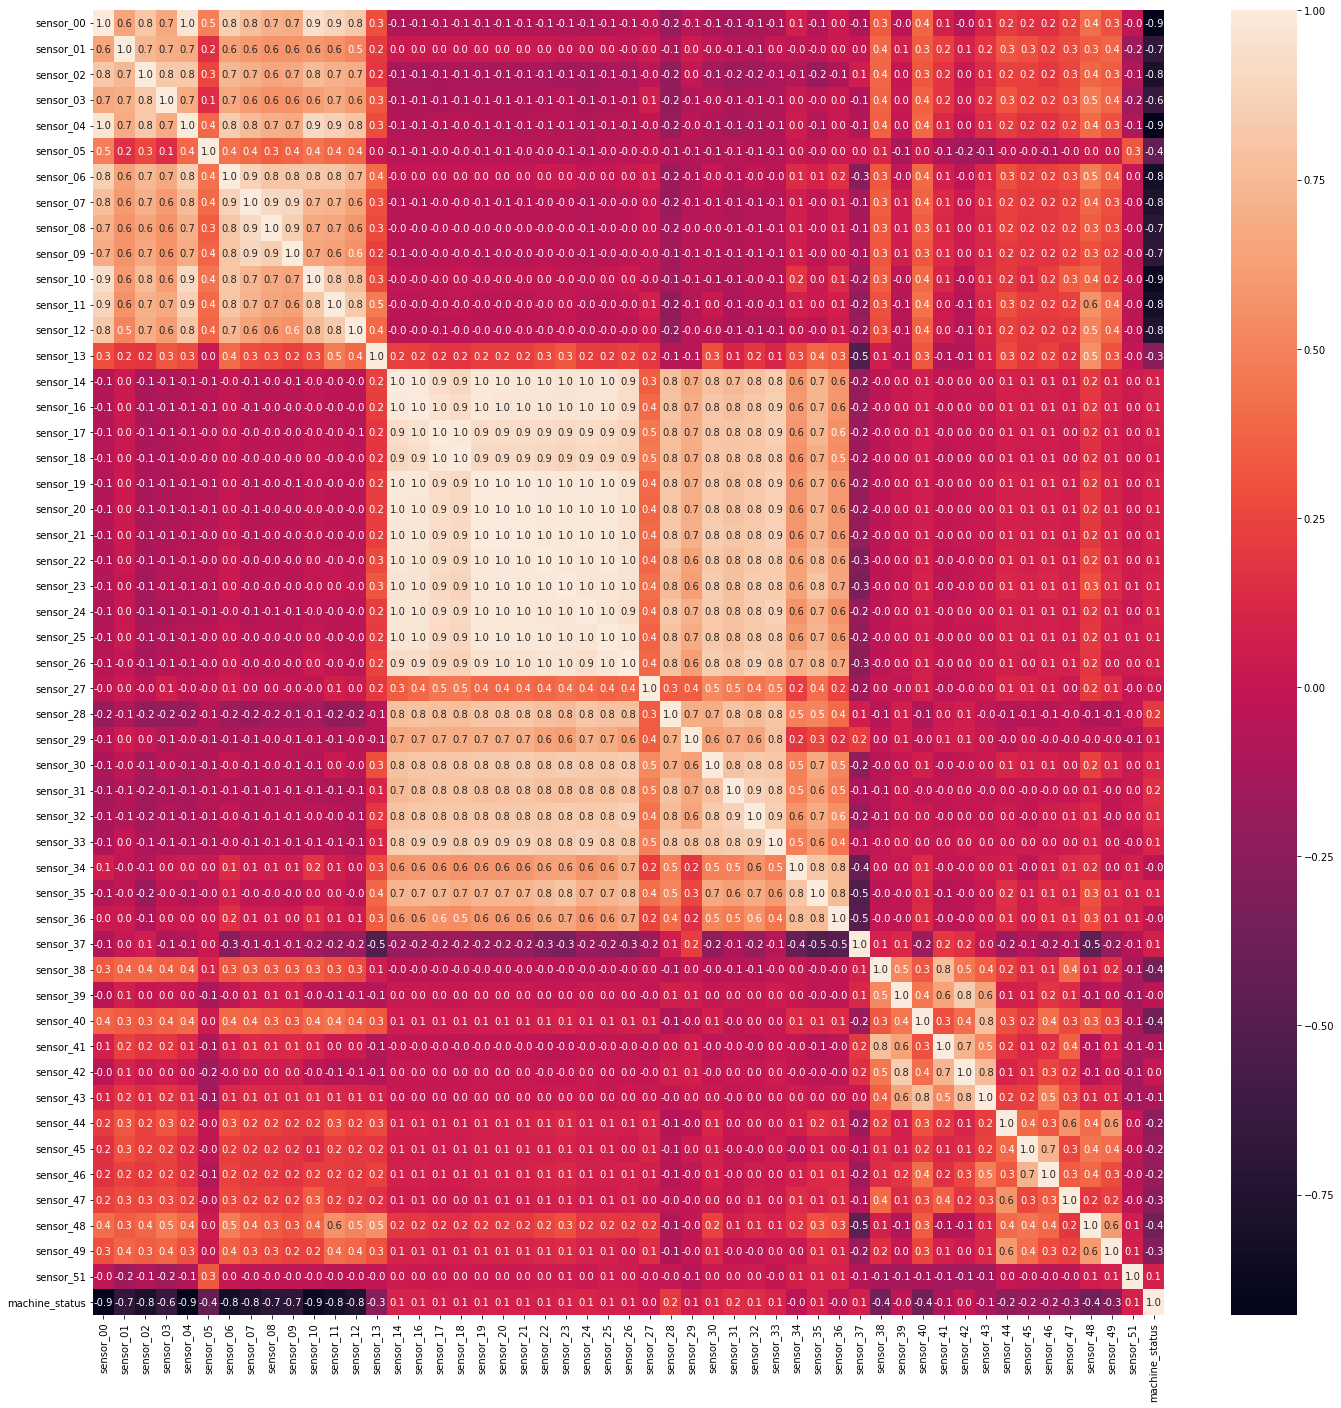

In [16]:
plt.figure(figsize=(24,24))
sns.heatmap(df.corr(), annot=True, fmt='.1f')

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sensor_00,220320.0,2.265018,0.631635,0.000000,2.419155,2.455556,2.499826,2.549016
sensor_01,220320.0,47.591376,3.295432,0.000000,46.310760,48.133680,49.479160,56.727430
sensor_02,220320.0,50.867193,3.667038,33.159720,50.390620,51.649300,52.777770,56.032990
sensor_03,220320.0,43.752374,2.418948,31.640620,42.838539,44.227428,45.312500,48.220490
sensor_04,220320.0,590.664866,144.037482,2.798032,626.620400,632.638916,637.615723,800.000000
sensor_05,220320.0,73.395897,17.298035,0.000000,69.976258,75.576145,80.911770,99.999880
sensor_06,220320.0,13.334002,2.417590,0.014468,13.317420,13.628470,14.539930,22.251160
sensor_07,220320.0,15.661840,2.454543,0.000000,15.856480,16.167530,16.427950,23.596640
sensor_08,220320.0,15.060121,2.211417,0.028935,15.147570,15.451390,15.697340,24.348960
sensor_09,220320.0,14.674948,2.238849,0.000000,15.010130,15.082470,15.118630,25.000000


- No mapa de calor tempos um grupo com alta correlação sensor_14 ao 26, análisando os dados do sensor 25 e 26 observamos uma correlação de 100% porém dos dados não são iguais, isso gerou uma hipótese de que os sensores tratam de um mesmo tipo de informação sobre a bomba.

In [18]:
df['machine_normal'] = df['machine_status'].apply(lambda x: 1 if MachineStatus.NORMAL.value == x else 0)

In [19]:
# Conferindo novo campo se foi gerado corretamente, como atribuimos 0 aos status BROKEN e RECOVERYING apenas o NORMAL deve possuir valor
df.groupby(['machine_status'])['machine_normal'].sum()

machine_status
1    205836
2         0
3         0
Name: machine_normal, dtype: int64

In [20]:
class DayPeriod(Enum):
  EARLY_MORNING = 0
  MORNING = 1
  NOON = 2
  AFTERNOON = 3
  EVENING = 4
  NIGHT = 5


def extract_day_period(date):
  if date.hour <= 4:
    return DayPeriod.EARLY_MORNING.value
  if date.hour <= 8:
    return DayPeriod.MORNING.value
  if date.hour <= 12:
    return DayPeriod.NOON.value
  if date.hour <= 16:
    return DayPeriod.AFTERNOON.value
  if date.hour <= 20:
    return DayPeriod.EVENING.value
  return DayPeriod.NIGHT.value

In [21]:
df['day_period'] = df['timestamp'].apply(lambda x: extract_day_period(x))
df['day_period'].unique()

array([0, 1, 2, 3, 4, 5])

<AxesSubplot:>

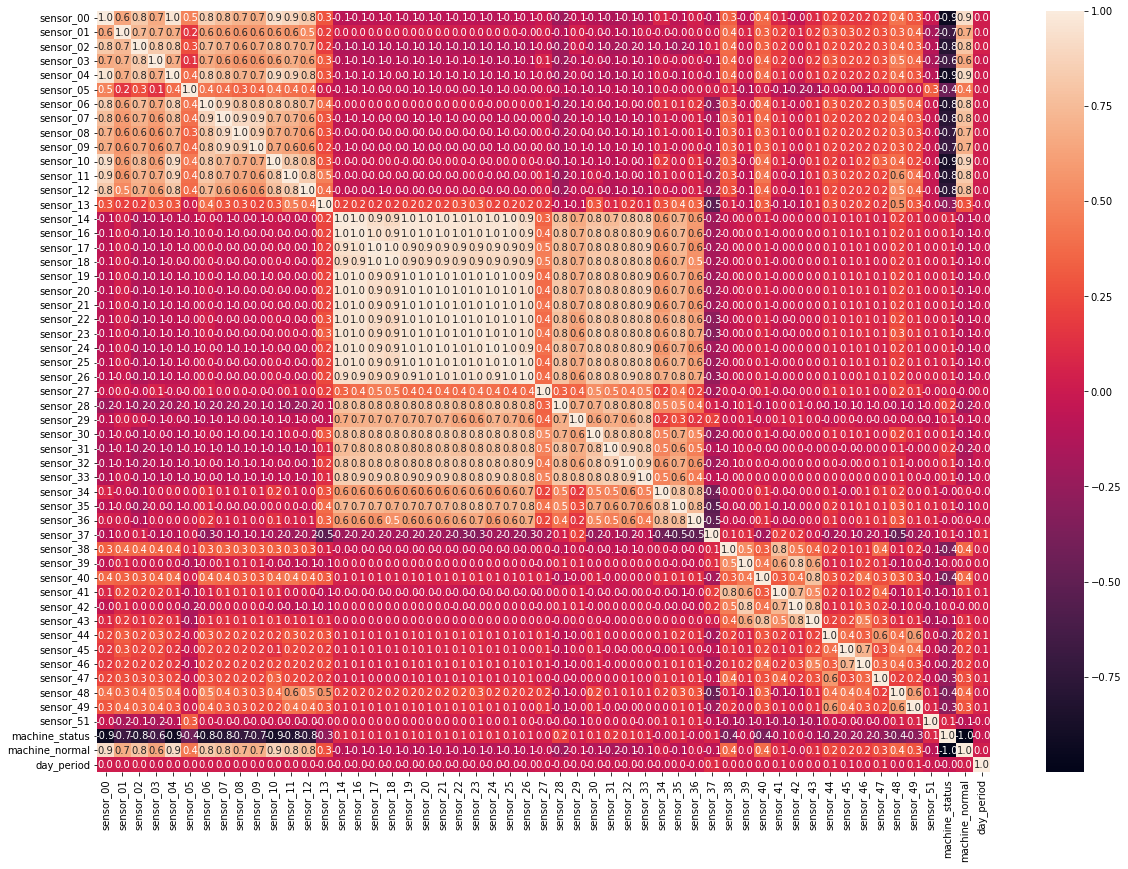

In [22]:
plt.figure(figsize=(20,14))
sns.heatmap(df.corr(), annot=True, fmt='.1f')

- Criamos o campo machine_normal que determina se a máquina está com status normal ou não
- No mapa de calor verificamos que os sensores_00 a 04 e 06 a 12 provavelmente captam as informações mais relevantes sobre a saúde da bomba, pois a correlação com machine_normal está sendo entre 0.6 e 0.9  
- Como periodo do dia não teve relevancia, ele será eliminado

### Análisando as features de maior importância dentro do dataframe 


In [23]:
df.drop('day_period', axis=1, inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 53 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       220320 non-null  datetime64[ns]
 1   sensor_00       220320 non-null  float64       
 2   sensor_01       220320 non-null  float64       
 3   sensor_02       220320 non-null  float64       
 4   sensor_03       220320 non-null  float64       
 5   sensor_04       220320 non-null  float64       
 6   sensor_05       220320 non-null  float64       
 7   sensor_06       220320 non-null  float64       
 8   sensor_07       220320 non-null  float64       
 9   sensor_08       220320 non-null  float64       
 10  sensor_09       220320 non-null  float64       
 11  sensor_10       220320 non-null  float64       
 12  sensor_11       220320 non-null  float64       
 13  sensor_12       220320 non-null  float64       
 14  sensor_13       220320 non-null  flo

- Abaixo vamos verificar quais features possuem mais importância usando o ExtraTreesClassifier

In [26]:
X = df[df.columns[1:-2].to_list()].to_numpy()
y = df['machine_normal']
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

[0.1789889  0.01404486 0.04917263 0.03014981 0.1356797  0.04798878
 0.02010135 0.04208672 0.05333226 0.03457482 0.06439416 0.0759546
 0.12192814 0.01141158 0.00177632 0.00110326 0.0007037  0.00045546
 0.00089627 0.00122817 0.00069257 0.0017374  0.00230774 0.00095088
 0.00135347 0.00144925 0.00056702 0.00258266 0.00149029 0.0019839
 0.00197915 0.00196458 0.00065353 0.00164503 0.002159   0.00536419
 0.00061839 0.0048913  0.00423173 0.00912942 0.00193277 0.00422207
 0.00610437 0.00102227 0.00173916 0.00884357 0.00163693 0.0224239
 0.00127774 0.01707423]


In [27]:
most_important = []
for sensor, importance in zip(df.columns[1:-2], model.feature_importances_):
  if importance >= 0.01:
    most_important.append((sensor, importance))

most_important.sort(reverse=True,key=lambda x: x[1])
most_important

[('sensor_00', 0.1789888967005159),
 ('sensor_04', 0.13567970247698474),
 ('sensor_12', 0.12192813986799278),
 ('sensor_11', 0.07595459968729079),
 ('sensor_10', 0.06439415500620096),
 ('sensor_08', 0.05333225796133385),
 ('sensor_02', 0.049172628881288594),
 ('sensor_05', 0.04798877743737714),
 ('sensor_07', 0.04208672010027234),
 ('sensor_09', 0.03457482168280584),
 ('sensor_03', 0.030149807506977423),
 ('sensor_48', 0.02242390131468053),
 ('sensor_06', 0.020101351790201283),
 ('sensor_51', 0.017074233872301364),
 ('sensor_01', 0.014044859698683196),
 ('sensor_13', 0.011411580450042213)]

- Acima podemos observar que os sensores de 00 á 12 estão entre os com maior importância, o que da mais força a nossa hipótese de que captam informações vitais sobre a saude da máquina

In [28]:
df_reduced = df[[*[sensor for sensor, importance in most_important], 'machine_status', 'machine_normal']].copy()
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       220320 non-null  float64
 1   sensor_04       220320 non-null  float64
 2   sensor_12       220320 non-null  float64
 3   sensor_11       220320 non-null  float64
 4   sensor_10       220320 non-null  float64
 5   sensor_08       220320 non-null  float64
 6   sensor_02       220320 non-null  float64
 7   sensor_05       220320 non-null  float64
 8   sensor_07       220320 non-null  float64
 9   sensor_09       220320 non-null  float64
 10  sensor_03       220320 non-null  float64
 11  sensor_48       220320 non-null  float64
 12  sensor_06       220320 non-null  float64
 13  sensor_51       220320 non-null  float64
 14  sensor_01       220320 non-null  float64
 15  sensor_13       220320 non-null  float64
 16  machine_status  220320 non-null  int64  
 17  machine_no

<AxesSubplot:xlabel='timestamp', ylabel='sensor_00'>

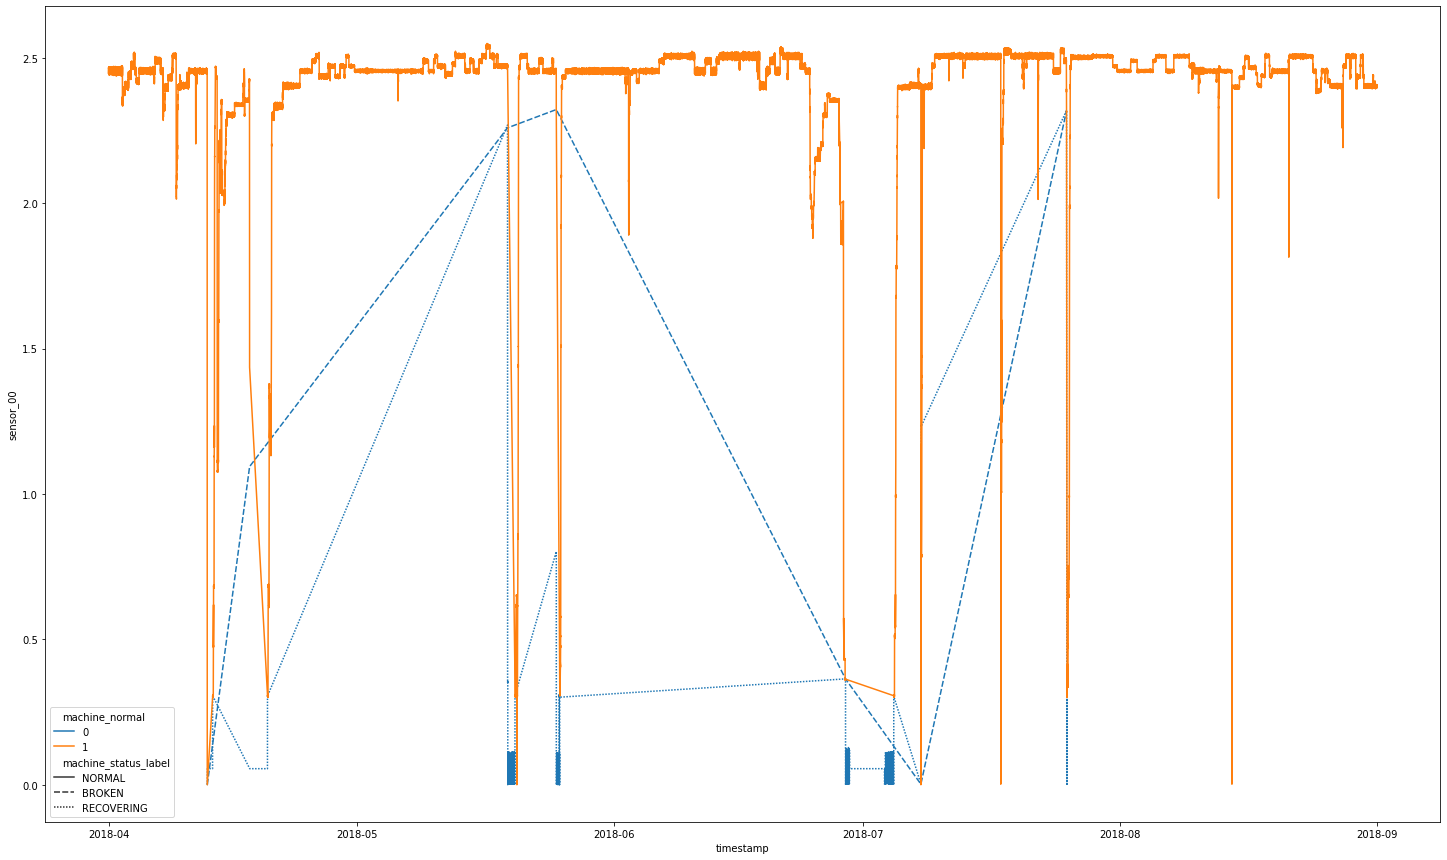

In [29]:
df_reduced['timestamp'] = df['timestamp']
df_reduced['machine_status_label'] = df_reduced['machine_status'].apply(lambda x: MachineStatus(x).name)
plt.subplots(figsize=(25,15))
sns.lineplot(x='timestamp', y='sensor_00',
             hue='machine_normal', style='machine_status_label',
             data=df_reduced)

- Vemos acima que quando o valor do sensor_00 fica abaixo de 1 a máquina tende a fica inoperante com status de recuperação e até mesmo quebrada

<AxesSubplot:xlabel='timestamp', ylabel='sensor_11'>

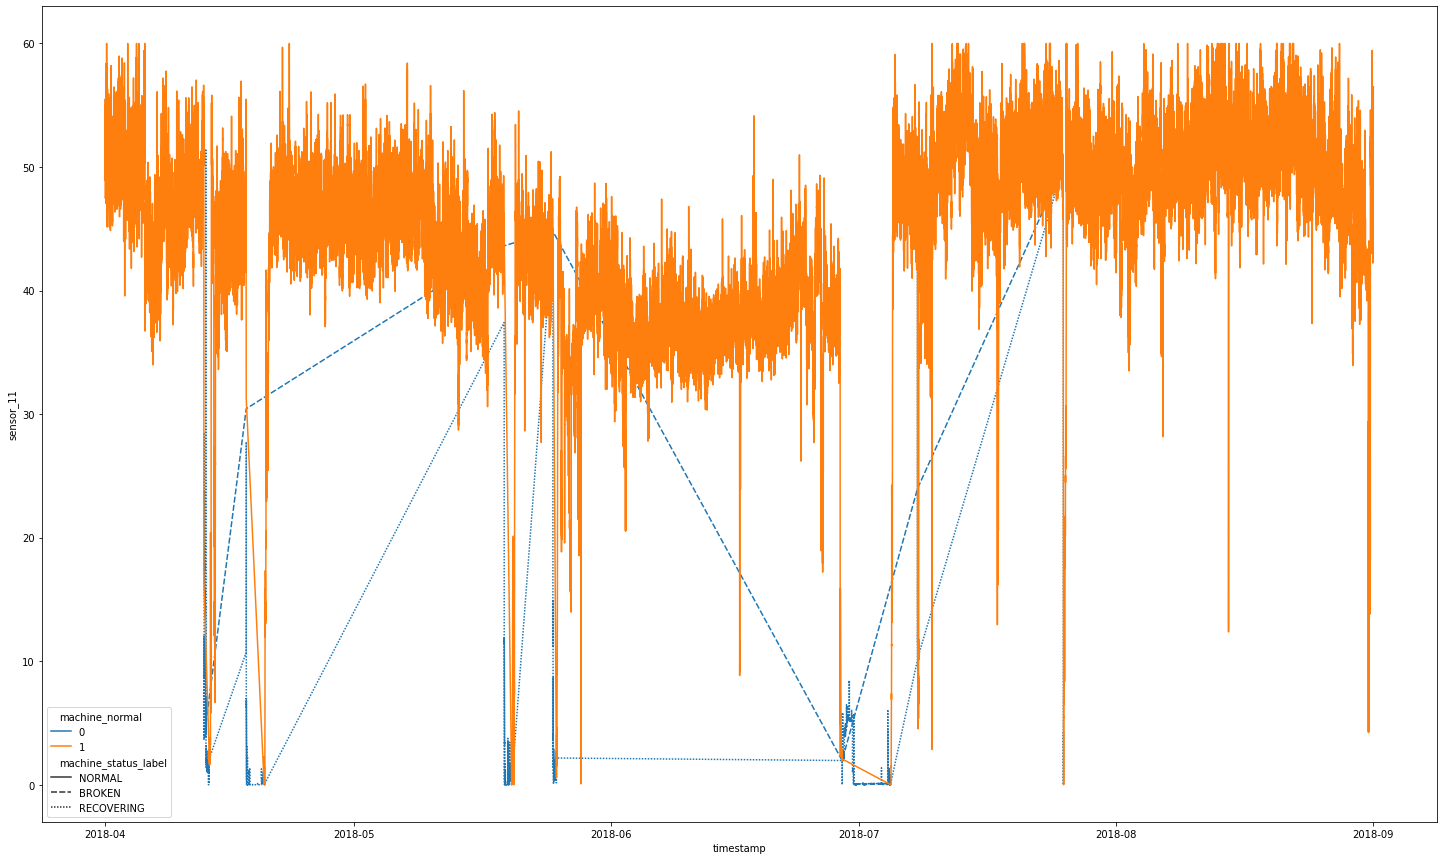

In [30]:
plt.subplots(figsize=(25,15))
sns.lineplot(x='timestamp', y='sensor_11',
             hue='machine_normal', style='machine_status_label',
             data=df_reduced)

<AxesSubplot:xlabel='timestamp', ylabel='sensor_04'>

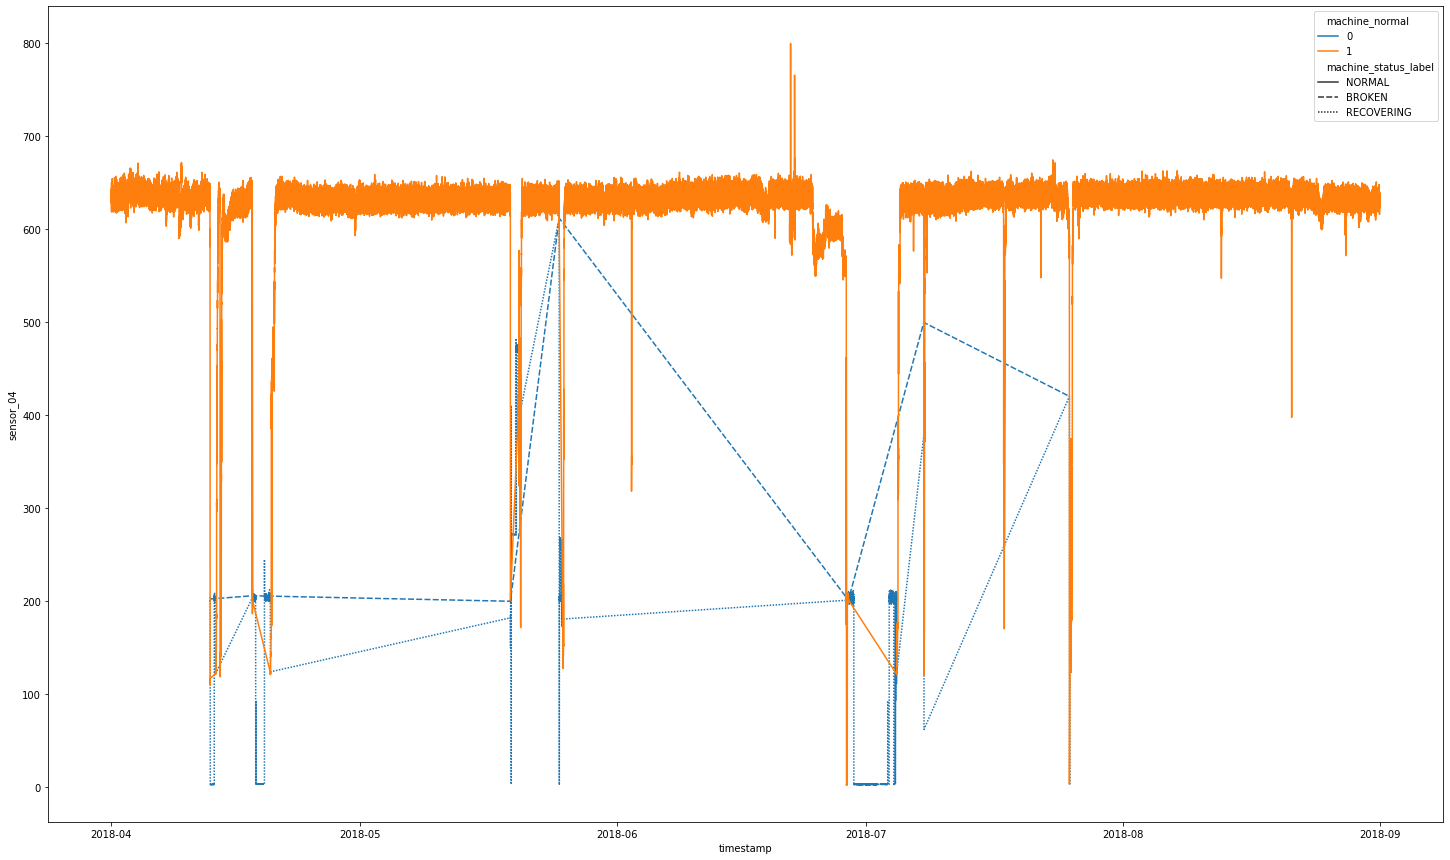

In [31]:
plt.subplots(figsize=(25,15))
sns.lineplot(x='timestamp', y='sensor_04',
             hue='machine_normal', style='machine_status_label',
             data=df_reduced)

- Com os gráficos dos sensores 11 e 04 criamos outra hipótese pois com a queda destes sensores as máquinas tendem a perder seu status normal. 

# Preparando dados para treinamento em rede neural
- Vai ser separado o campo se a máquina está normal ou não para ser o target
- Os demais campos serão colocados em escala
- Então iremos separar 25% para teste e 75% será utilizado no treino

In [32]:
data = df_reduced[[*df_reduced.columns[:-4], 'timestamp', 'machine_normal']].copy()
data['timestamp'] = data['timestamp'].apply(lambda x: x.timestamp())
X, y = data.values[:, :-1], data.values[:, -1]
y = y.astype('int64')
y

array([1, 1, 1, ..., 1, 1, 1])

In [33]:
X = X.astype('float64')
X

array([[2.46539400e+00, 6.34375000e+02, 3.11171600e+01, ...,
        4.70920100e+01, 1.68135300e+00, 1.52254080e+09],
       [2.46539400e+00, 6.34375000e+02, 3.11171600e+01, ...,
        4.70920100e+01, 1.68135300e+00, 1.52254086e+09],
       [2.44473400e+00, 6.38888900e+02, 3.20889400e+01, ...,
        4.73524300e+01, 1.70847400e+00, 1.52254092e+09],
       ...,
       [2.39652800e+00, 6.25925903e+02, 3.85267800e+01, ...,
        4.76996498e+01, 1.31886600e+01, 1.53575982e+09],
       [2.40636600e+00, 6.35648100e+02, 3.88915900e+01, ...,
        4.76996498e+01, 1.31734600e+01, 1.53575988e+09],
       [2.39652800e+00, 6.39814800e+02, 3.94095700e+01, ...,
        4.76996498e+01, 1.31259300e+01, 1.53575994e+09]])

In [34]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X

array([[ 0.31723416,  0.30346429,  0.19583041, ..., -0.15153326,
        -0.78205579, -1.73204295],
       [ 0.31723416,  0.30346429,  0.19583041, ..., -0.15153326,
        -0.78205579, -1.73202722],
       [ 0.28452534,  0.33480274,  0.291909  , ..., -0.07250855,
        -0.77812608, -1.7320115 ],
       ...,
       [ 0.2082058 ,  0.24480515,  0.9284096 , ...,  0.03285565,
         0.88530168,  1.7320115 ],
       [ 0.22378128,  0.31230299,  0.96447788, ...,  0.03285565,
         0.88309927,  1.73202722],
       [ 0.2082058 ,  0.34123094,  1.01568986, ...,  0.03285565,
         0.87621239,  1.73204295]])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [36]:
n_features = X_train.shape[1]
n_features

17

## Teste com redes neurais para verificar acuracia

In [37]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(n_features,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
5164/5164 [==============================] - 20s 4ms/step - loss: 0.0339 - accuracy: 0.9348
Epoch 2/25
5164/5164 [==============================] - 10s 2ms/step - loss: 0.0068 - accuracy: 0.9348
Epoch 3/25
5164/5164 [==============================] - 15s 3ms/step - loss: 0.0042 - accuracy: 0.9348
Epoch 4/25
5164/5164 [==============================] - 13s 3ms/step - loss: 0.0035 - accuracy: 0.9348
Epoch 5/25
5164/5164 [==============================] - 13s 2ms/step - loss: 0.0033 - accuracy: 0.9348
Epoch 6/25
5164/5164 [==============================] - 12s 2ms/step - loss: 0.0030 - accuracy: 0.9348
Epoch 7/25
5164/5164 [==============================] - 11s 2ms/step - loss: 0.0028 - accuracy: 0.9348
Epoch 8/25
5164/5164 [==============================] - 12s 2ms/step - loss: 0.0026 - accuracy: 0.9348
Epoch 9/25
5164/5164 [==============================] - 11s 2ms/step - loss: 0.0025 - accuracy: 0.9348
Epoch 10/25
5164/5164 [==============================] - 9s 2ms/step - lo

In [39]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.933


In [40]:
def evaluate_model(proba, y_test, y_pred):
    s1 = accuracy_score(y_test, y_pred).round(3)
    s2 = precision_score(y_test, y_pred, average='weighted').round(3)
    s3 = recall_score(y_test, y_pred, average='weighted').round(3)
    s4 = f1_score(y_test, y_pred, average='weighted').round(3)
    s5 = roc_auc_score(y_test, proba, average='weighted').round(3)
    print("Accuracy ", s1)
    print("Precision ", s2)
    print("Recall ", s3)
    print("f1 score ", s4)
    print("ROC_AUC ", s5)

In [41]:
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=50, activation='relu', solver='adam', random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

prob = mlp.predict_proba(X_test)[:,1]
evaluate_model(prob, y_test, y_pred)

Accuracy  0.999
Precision  0.999
Recall  0.999
f1 score  0.999
ROC_AUC  1.0
